In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [3]:
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator

color_map = {
    'cyan': '#66c2a5',
    'orange': '#ff7f00',
    'blue': '#8da0cb',
    'purple': '#7570b3',
    'pink': '#fccde5',
    'green': '#33a02c',
    'yellow': '#ffd92f',
    'brown': '#e5c494',
    'magenta': '#f1598a',
    'grey': '0.3'
}

In [4]:
import glob
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from spec_to_flux import spec_to_flux, spec_to_mag
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

## Distance modulus

In [6]:
# SN metadata

z = 0.02736
z_unc = 0.00007
t_max_mjd = 59722.77 # t_max_B
ebv = 0.032
rv = 3.1

# tfl = 58972.46296299994


In [7]:
cosmo = np.loadtxt('SN2022joj_cosmo.txt')
print('Luminosity distances =', cosmo[6], 'Mpc')

distmod = 5 * np.log10(cosmo[6] * 1e6 / 10)
print('Distance modulus = {:.2f}'.format(distmod))


Luminosity distances = 119.49 Mpc
Distance modulus = 35.39


## Light curves

In [7]:
import pandas as pd
from astropy.table import Table

In [8]:
joj_ZTF = pd.read_csv('./ZTF22aajijjf_forced_fnu.csv')
joj_ZTF['MJD'] = joj_ZTF['jd'] - 2400000.5
joj_ZTF['phase'] = (joj_ZTF['MJD'] - t_max_mjd) / (1 + z)
joj_ZTF['fnu_microJy'] = joj_ZTF['fnu_microJy'] * (1 + z)
joj_ZTF['fnu_microJy_unc'] = joj_ZTF['fnu_microJy_unc'] * (1 + z)
arg = (joj_ZTF['phase'] <= 150) & (joj_ZTF['phase'] >= -25)
joj_ZTF = joj_ZTF[arg]
joj_ZTF['mag'] = -2.5 * np.log10(joj_ZTF['fnu_microJy'] * 1e-6/3631)
joj_ZTF['mag_err_u'] = -2.5 * np.log10((joj_ZTF['fnu_microJy'] - joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) - joj_ZTF['mag']
joj_ZTF['mag_err_l'] = 2.5 * np.log10((joj_ZTF['fnu_microJy'] + joj_ZTF['fnu_microJy_unc']) * 1e-6/3631) + joj_ZTF['mag']
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ZTF_g'].assign(passband='ztfg')
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ZTF_r'].assign(passband='ztfr')
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ZTF_i'].assign(passband='ztfi')
joj_ZTF = pd.concat([joj_ZTF_g, joj_ZTF_r, joj_ZTF_i])


/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/chang/miniconda3/envs/astron/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [9]:
# joj_ZTF = joj_ZTF[~np.isnan(joj_ZTF['mag'])]
joj_ZTF_g = joj_ZTF[joj_ZTF['passband'] == 'ztfg']
joj_ZTF_r = joj_ZTF[joj_ZTF['passband'] == 'ztfr']
joj_ZTF_i = joj_ZTF[joj_ZTF['passband'] == 'ztfi']

## 1-D DDet models

In [8]:
import h5py

spec1 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii')
spec1 = data_binning(np.array([spec1[:, 0], spec1[:, 1], np.ones_like(spec1[:, 0])]).T, size=5)
spec2 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220523_Kast.flm')
spec3 = np.loadtxt('../spectroscopy/data/ZTF22aajijjf_20220601_NOT_ALFOSC.ascii')

### Polin+2019

In [ ]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    # t_max = 17

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(time[ind] - t_max, fit_g, color="tab:blue")
    ax[0].plot(time[ind] - t_max, fit_r, color="tab:orange")
    ax[0].plot(time[ind] - t_max, fit_i, color="tab:red")

    ax[0].errorbar(
        (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_g["mag"] - distmod,
        yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:blue",
    )
    ax[0].errorbar(
        (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_r["mag"] - distmod,
        yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:orange",
    )
    ax[0].errorbar(
        (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
        joj_ZTF_i["mag"] - distmod,
        yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
        fmt="o",
        capsize=3,
        color="tab:red",
    )
    ax[0].invert_yaxis()
    ax[0].set_ylim(-15.8, -19.8)
    ax[0].set_xlim(-18, 18)
    ax[0].set_xlabel("Phase [day]")
    ax[0].set_ylabel("mag")
    ax[0].set_title(f"{mc} + {ms}")

    idx_wv = (wv0 > 3500) & (wv0 < 9500)
    phases = np.array([-12.1, 2.52])
    specs = [spec1, spec2]
    for k in range(2):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        ax[1].plot(
            wv0[idx_wv],
            Flam[phase_idx][idx_wv]
            / np.median(Flam[phase_idx][(wv0 > 5500) & (wv0 < 6500)])
            - 3 * k,
            color=".5",
            alpha=0.5,
        )
        ax[1].plot(
            specs[k][:, 0] / (1 + z),
            specs[k][:, 1]
            / np.median(
                specs[k][:, 1][
                    (specs[k][:, 0] / (1 + z) > 5500)
                    & (specs[k][:, 0] / (1 + z) < 6500)
                ]
            )
            - 3 * k,
            color="k",
        )
        ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 3 * k, color="k")
    ax[1].set_xlabel("Wavelength [Ang]")
    plt.show()

In [ ]:
models = sorted(
    glob.glob(
        "/Users/chang/Desktop/SNIa/DoubleDetonationModels/Polin2019/spectra/good_1.[0-1]*"
    )
)
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    mod = model.split("/")[-1]
    mc, ms = mod.split("_")[-3], mod.split("_")[-2]
    if (float(ms) < 0.03) or (float(ms) > 0.05):
        continue
    with h5py.File(model, "r") as f:
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        Flam = np.array(
            [
                (np.flip(fnu)).to(
                    u.erg / u.s / u.cm**2 / u.AA,
                    equivalencies=u.spectral_density(wv * u.AA),
                )
                for fnu in Fnu
            ]
        ) / (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam *= E_Gal * E_Host

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    for k, fl in enumerate(Flam[ind]):
        fit_i[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
        )[0]
        fit_r[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
        )[0]
        fit_g[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
        )[0]
        fit_B[k] = spec_to_mag(
            [wv, fl, np.ones_like(wv, dtype=float)],
            flt=np.loadtxt("./filters/Bessell_B.dat"),
        )[0]
    t_max = time[ind][np.argmin(fit_B)]
    print(t_max)
    np.savetxt(
        f"./Polin+19_model/mc_{mc}_ms_{ms}_lc.txt",
        np.array([time[ind], fit_g, fit_r, fit_i, fit_B]).T,
        fmt="%.2f %.3f %.3f %.3f %.3f",
        header="Time ZTFg ZTFr ZTFi B",
    )

    idx_wv = (wv0 > 3000) & (wv0 < 9500)
    phases = np.array([-13, -12, -11, 0, 1, 2, 3])
    for k in range(len(phases)):
        phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
        np.savetxt(
            f"./Polin+19_model/mc_{mc}_ms_{ms}_phase_{phases[k]}_spec.txt",
            np.array(
                [
                    wv,
                    Flam[phase_idx],  # 10 pc --> D_L Mpc
                ]
            ).T[idx_wv, :],
            fmt="%.4f %.4e",
            header="time_explosion = {}\n".format(time[phase_idx]),
        )

### Shen+2021

In [ ]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_??e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [ ]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.10_*e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):
            from scipy.integrate import trapz

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [ ]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_[3-9]e5.h5"))
filters = sorted(glob.glob("./filters/*P48*"))

for model in models:
    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind][::2])
    fit_r = np.empty_like(time[ind][::2])
    fit_g = np.empty_like(time[ind][::2])
    fit_B = np.empty_like(time[ind][::2])
    for i in [2, 4, 6, 7]:
        for k, fl in enumerate(Flam[i][ind][::2]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][::2][np.argmin(fit_B)]
        print(t_max)
        # if t_max <= 15:
        #     print('rise time too short!')
        #     continue

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].plot(time[ind][::2] - t_max, fit_g, color="tab:blue")
        ax[0].plot(time[ind][::2] - t_max, fit_r, color="tab:orange")
        ax[0].plot(time[ind][::2] - t_max, fit_i, color="tab:red")
        ax[0].errorbar(
            (joj_ZTF_g["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_g["mag"] - distmod,
            yerr=[joj_ZTF_g["mag_err_l"], joj_ZTF_g["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:blue",
        )
        ax[0].errorbar(
            (joj_ZTF_r["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_r["mag"] - distmod,
            yerr=[joj_ZTF_r["mag_err_l"], joj_ZTF_r["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:orange",
        )
        ax[0].errorbar(
            (joj_ZTF_i["MJD"] - t_max_mjd) / (1 + z),
            joj_ZTF_i["mag"] - distmod,
            yerr=[joj_ZTF_i["mag_err_l"], joj_ZTF_i["mag_err_u"]],
            fmt="o",
            capsize=3,
            color="tab:red",
        )
        ax[0].invert_yaxis()
        ax[0].set_ylim(-15.8, -19.8)
        ax[0].set_xlim(-18, 18)
        ax[0].set_xlabel("Phase [day]")
        ax[0].set_ylabel("mag")
        ax[0].set_title(r"$\rho_5$ = {}, $\mu$ = {:.2f}".format(rho, cos_theta[i]))

        phases = np.array([-12.1, 2.52])
        specs = [spec1, spec2]
        for k in range(2):

            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 9500)
            Flam_bin = data_binning(
                np.array(
                    [wv0[idx_wv], Flam[i][phase_idx][idx_wv], np.ones_like(wv0[idx_wv])]
                ).T,
                size=10,
            )
            ax[1].plot(
                Flam_bin[:, 0],
                Flam_bin[:, 1]
                / np.median(
                    Flam_bin[(Flam_bin[:, 0] > 5500) & (Flam_bin[:, 0] < 6500), 1]
                )
                - 3.5 * k,
                color=".5",
                alpha=0.5,
            )
            ax[1].plot(
                specs[k][:, 0] / (1 + z),
                specs[k][:, 1]
                / np.median(
                    specs[k][:, 1][
                        (specs[k][:, 0] / (1 + z) > 5500)
                        & (specs[k][:, 0] / (1 + z) < 6500)
                    ]
                )
                - 3.5 * k,
                color="k",
            )
            ax[1].text(s="{:.0f}".format(phases[k]), x=8800, y=1.1 - 4 * k, color="k")
        ax[1].set_xlabel("Wavelength [Ang]")
        plt.show()

In [100]:
# models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.0_6e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    # if (m_tot != 1.0) or (rho != 6): continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 1) & (time < 35)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    fit_B_z0 = np.empty_like(time[ind])
    for i in [2, 4, 6, 8]:
        for k, fl in enumerate(Flam[i][ind]):
            # fit_i[k] = spec_to_mag(
            #     [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            # )[0]
            # fit_r[k] = spec_to_mag(
            #     [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            # )[0]
            # fit_g[k] = spec_to_mag(
            #     [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            # )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            # fit_B_z0[k] = spec_to_mag(
            #     [wv0, fl / (E_Gal * E_Host) * (1 + z), np.ones_like(wv, dtype=float)],
            #     flt=np.loadtxt("./filters/Bessell_B.dat"),
            # )[0]
            # fit_B_0[k] = spec_to_mag(
            #     [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
            #     flt=np.loadtxt("./filters/Bessell_B.dat"),
            # )[0]
        # np.savetxt(
        #     "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_lc.txt".format(
        #         m_tot, rho, cos_theta[i] * 100
        #     ),
        #     np.array([time[ind], fit_g, fit_r, fit_i, fit_B, fit_B_z0, fit_B_0]).T,
        #     fmt="%.2f %.3f %.3f %.3f %.3f %.3f %.3f",
        #     header="Time ZTFg ZTFr ZTFi B B(intrinsic) B(unreddened)",
        # )
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)
        phases = [-10, -9]
        for phase in phases:
            phase_idx = np.argmin(np.abs(time - phase - t_max))
            idx_wv = (wv0 > 3000) & (wv0 < 10000)
            np.savetxt(
                "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_phase_{}_spec.txt".format(
                    m_tot, rho, cos_theta[i] * 100, phase
                ),
                np.array(
                    [
                        wv,
                        Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx]),
            )

1.0 6.0


/Users/chang/Desktop/SN2022joj/photometry/../tools/spec_to_flux.py:44: RuntimeWarning: invalid value encountered in log10
  mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2


16.75
16.25
15.25
14.75


In [ ]:
models = sorted(glob.glob("/Users/chang/Desktop/SNIa/Shen2021/1.*e5.h5"))
filters = sorted(glob.glob("./filters/P48*"))

for model in models:
    m_tot = float(model.split("/")[-1].split("_")[0])
    rho = float(model.split("_")[-1].split(".")[0][:-2])
    if ((m_tot < 1.1) and (rho < 6)) or ((m_tot == 1.1) and (rho == 2)):
        continue
    print(m_tot, rho)

    with h5py.File(model, "r") as f:
        rho = model.split("_")[-1].split(".")[0][:-2]
        cos_theta = np.array(f["mu"])
        Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
        time = np.array(f["time"][:] / 86400)
        nu = np.array(f["nu"][:])
        wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + z)
        E_Gal = 10 ** (-0.4 * calALambda(wv=wv, EBV=ebv, RV=3.1))
        E_Host = 10 ** (-0.4 * calALambda(wv=wv0, EBV=0, RV=3.1))
        Flam = [
            np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.cm**2 / u.AA,
                        equivalencies=u.spectral_density(wv * u.AA),
                    )
                    for fnu in Fnu
                ]
            )
            / (1 + z)
            * E_Gal
            * E_Host
            for i in np.arange(len(cos_theta))
        ]

    ind = (time > 11) & (time < 23)
    fit_i = np.empty_like(time[ind])
    fit_r = np.empty_like(time[ind])
    fit_g = np.empty_like(time[ind])
    fit_B = np.empty_like(time[ind])
    fit_B_0 = np.empty_like(time[ind])
    # if m_tot == 1 and rho == '6':
    #     i_range = [2, 4, 6]
    # else:
    #     i_range = [0, 2, 4]
    i_range = [2, 7]
    for i in i_range:
        for k, fl in enumerate(Flam[i][ind]):
            fit_i[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[0])
            )[0]
            fit_r[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[1])
            )[0]
            fit_g[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)], flt=np.loadtxt(filters[2])
            )[0]
            fit_B[k] = spec_to_mag(
                [wv, fl, np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
            fit_B_0[k] = spec_to_mag(
                [wv, fl / (E_Gal * E_Host), np.ones_like(wv, dtype=float)],
                flt=np.loadtxt("./filters/Bessell_B.dat"),
            )[0]
        t_max = time[ind][np.argmin(fit_B)]
        print(t_max)

        phases = [-13, -12, -11, 0, 1, 2, 3]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            idx_wv = (wv0 > 3000) & (wv0 < 10000)

            np.savetxt(
                "./Shen+21_model/m_{:.1f}_dens_{}e5_mu_{:.0f}_phase_{:.0f}_spec.txt".format(
                    m_tot, rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv,
                        Flam[i][phase_idx],  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx]),
            )

        phases = [-12.1, 0, 2.52]
        for k in range(len(phases)):
            phase_idx = np.argmin(np.abs(time - (t_max + phases[k])))
            log_Lsun = np.log10(
                trapz(
                    (Flam[i][phase_idx] / (E_Gal * E_Host))[idx_wv],
                    wv0[idx_wv],
                )
                * (4 * np.pi * (10 * u.pc).to("cm").value ** 2)
                * (1 + z)
                / 3.828e33  # Lsun in cgs
            )
            np.savetxt(
                "../TARDIS/Shen+2021/d{}e5_mu_{:.0f}_phase_{:.1f}_spec.txt".format(
                    rho, cos_theta[i] * 100, phases[k]
                ),
                np.array(
                    [
                        wv0,
                        Flam[i][phase_idx]
                        / (E_Gal * E_Host)
                        * (1 + z)
                        * (10e-6 / 114.48) ** 2,  # 10 pc --> D_L Mpc
                    ]
                ).T[idx_wv, :],
                fmt="%.4f %.4e",
                header="time_explosion = {}\n".format(time[phase_idx])
                + "log_Lsun = {:.2f}".format(log_Lsun),
            )

## Modeling the silicon features

In [ ]:
sys.path.append('../spectroscopy')

from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736 #redshift
synth_spec = [f for f in sorted(glob.glob('./Shen+21_model/*mu*spec*')) if not 'phase' in f]
synth_lc = sorted(glob.glob('./Shen+21_model/*mu*lc*'))

def lambda_rf(lambda_0, vel):
    c = 2.99792458e5
    beta = vel / c
    lambda_rf = np.sqrt((1 + beta) / (1 - beta)) * lambda_0
    return lambda_rf

In [ ]:
synth_spec

In [ ]:
syn_mc = np.empty_like(synth_spec, dtype=float)
syn_rho = np.empty_like(synth_spec, dtype=float)
syn_mu = np.empty_like(synth_spec, dtype=float)
v_Si_Shen = np.empty_like(synth_spec, dtype=float)
v_Si_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_6355_err_Shen = np.empty_like(synth_spec, dtype=float)
EW_Si_5972_err_Shen = np.empty_like(synth_spec, dtype=float)

for k in range(len(synth_spec)):
    syn_mc[k] = float(synth_spec[k].split('_')[2])
    syn_rho[k] = float(synth_spec[k].split('_')[4])
    syn_mu[k] = float(synth_spec[k].split('_')[6])
    print(syn_mc[k], syn_rho[k], syn_mu[k])
    Spec = SpectrumSN_Lines(synth_spec[k], z=z, snr=30)
    Spec.add_line("SiII0", 5750, 6450, lines=[6371.359, 6347.103])
    Spec.line["SiII0"].LS_estimator()
    v_temp = Spec.line["SiII0"].theta_LS[2]

    Spec.add_line(
        "SiII_6355",
        lambda_rf(6347.103, v_temp) - 250,
        lambda_rf(6371.359, v_temp) + 250,
        lines=[6371.359, 6347.103],
    )
    print(Spec.snr)
    try:
        Spec.line["SiII_6355"].MCMC_sampler(
            vel_mean_mu=[-1e4],
            vel_mean_sig=[3e3],
            initial=Spec.line["SiII0"].theta_LS,
            vel_var_lim=[1e4, 1e10],
            A_lim=[-1e6, 0],
        )
    except:
        print(Spec.line["SiII0"].theta_LS)
        break
    v_Si_Shen[k] = Spec.line["SiII_6355"].theta_MCMC[2]

    Spec.add_line(
        "SiII_5972",
        lambda_rf(5957.561, v_temp) - 160,
        lambda_rf(5978.929, v_temp) + 180,
        lines=[5957.561, 5978.929],
    )
    vel_var_6355 = np.exp(Spec.line["SiII_6355"].theta_MCMC[3])
    Spec.line["SiII_5972"].MCMC_sampler(
        vel_mean_mu=[v_Si_Shen[k]],
        vel_mean_sig=[5e2],
        initial=Spec.line["SiII_6355"].theta_MCMC,
        vel_var_lim=[vel_var_6355 / 2, vel_var_6355 * 1.2],
        A_lim=[-1e6, 0],
    )

    EW_Si_6355_Shen[k], EW_Si_5972_Shen[k] = (
        Spec.line["SiII_6355"].EW[0],
        Spec.line["SiII_5972"].EW[0],
    )
    EW_Si_6355_err_Shen[k], EW_Si_5972_err_Shen[k] = (
        Spec.line["SiII_6355"].sig_EW[0],
        Spec.line["SiII_5972"].sig_EW[0],
    )
    # if (
    #     np.abs(
    #         Spec.line["SiII_5972"].theta_MCMC[2] - Spec.line["SiII_6355"].theta_MCMC[2]
    #     )
    #     > 2000
    # ):
    #     EW_Si_5972_Shen[k] = np.nan
    # if np.abs(syn_mu[k]) >= 90:
    #     EW_Si_6355_Shen[k], EW_Si_5972_Shen[k], v_Si_Shen[k] = np.nan, np.nan, np.nan
    plt.show()

In [ ]:
M_B_max_Shen = np.empty_like(synth_lc, dtype=float)

for k in range(len(synth_lc)):
    lc = np.loadtxt(synth_lc[k])
    M_B = lc[:, -1]
    M_B_max_Shen[k] = M_B.min()

In [ ]:
np.savetxt(
    fname="./Shen+21_model/1.1Msun_spec_para.dat",
    X=np.array(
        [
            syn_mc,
            syn_mu / 100,
            syn_rho,
            M_B_max_Shen,
            v_Si_Shen,
            v_Si_err_Shen,
            EW_Si_5972_Shen,
            EW_Si_5972_err_Shen,
            EW_Si_6355_Shen,
            EW_Si_6355_err_Shen,
        ]
    ).T,
    fmt="%.1f %.2f %.0f %.3f %.3f %.3f %.3f %.3f %.3f %.3f",
    header="m mu density M_B_max v_Si v_Si_err EW_Si_5972 EW_Si_5972_err EW_Si_6355 EW_Si_6355_err",
)

## Model comparison plot

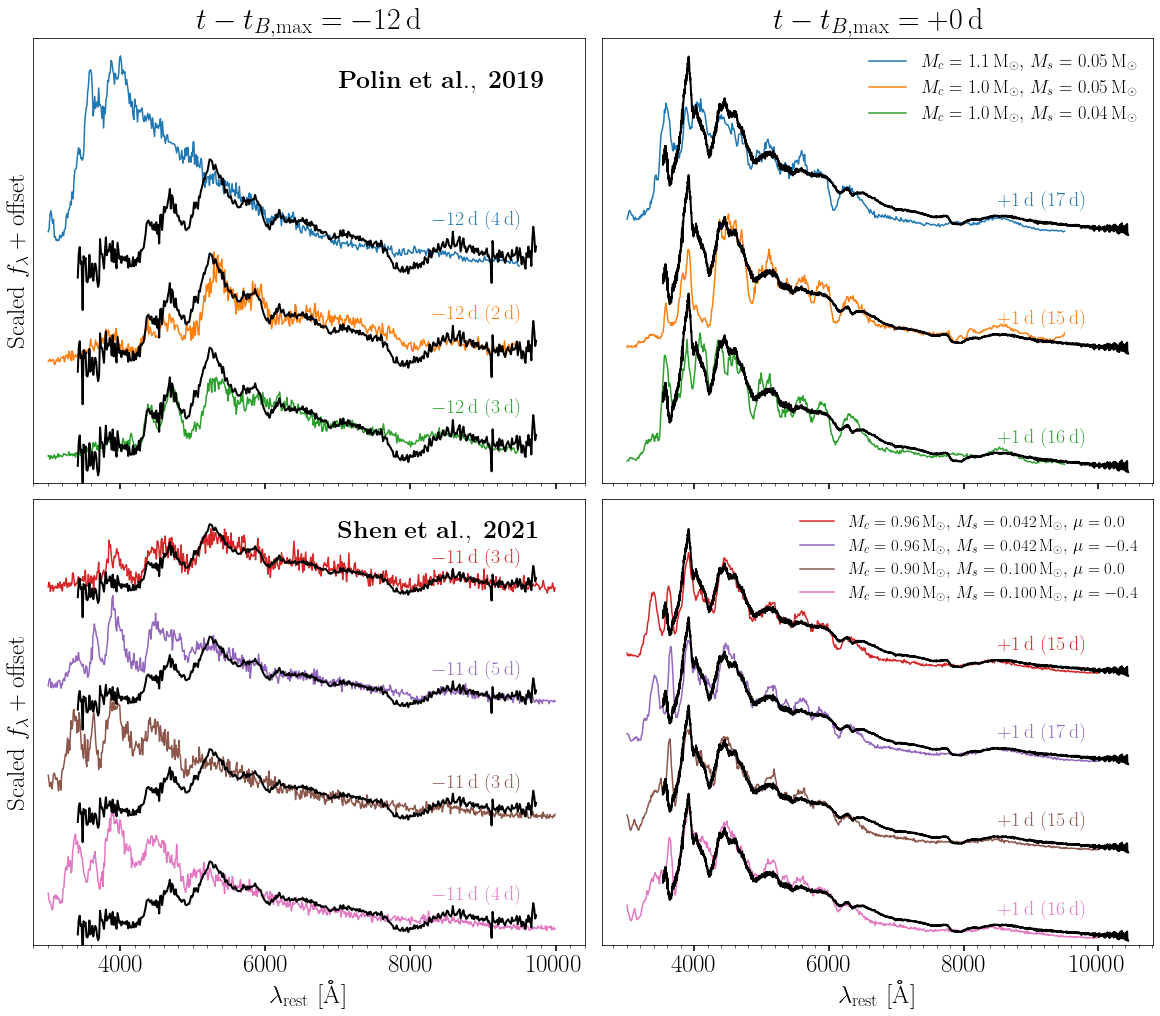

In [38]:
# prop_cycle = plt.rcParams["axes.prop_cycle"]
import seaborn as sns

colors = sns.color_palette()

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex="col", constrained_layout=True)

h0 = np.array([[1.5, 2.1], [2.9, 1.9]])

# Polin+2019 models
ax = axes[0]
models_Polin = sorted(glob.glob("./Polin+19_model/*1*phase*spec*"), reverse=True)
k = -1
for model in models_Polin:
    mc = float(model.split("_")[2])
    ms = float(model.split("_")[4])
    if (ms >= 0.06) or (ms <= 0.03) or (mc > 1.1):
        continue
    phase = float(model.split("_")[-2])
    if phase == -12:
        a = ax[0]
        h = h0[0, 0]
    elif phase == 1:
        a = ax[1]
        k += 1
        h = h0[0, 1]
    else:
        continue
    if phase < -0.5:
        phase_max = "-{:.0f}".format(np.abs(phase)) + r"\,\mathrm{d}"
    else:
        phase_max = "+{:.0f}".format(np.abs(phase)) + r"\,\mathrm{d}"
    with open(model, "r") as f:
        phase_exp = (
            str(int(float(f.readline().split("=")[-1].split("\n")[0])))
            + r"\,\mathrm{d}"
        )
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        label=f"$M_c = {mc}\,"
        + r"\mathrm{M_\odot},\,"
        + f"M_s = {ms}\,"
        + r"\mathrm{M_\odot}$",
        color=colors[k],
    )
    a.text(
        8500 - 200 * (phase < -9),
        -(k - 0.25 - 0.3 * (phase < -5)) * h,
        rf"${phase_max}\ ({phase_exp})$",
        color=colors[k],
        fontsize=20,
    )

# Shen+2021 models
ax = axes[1]
models_Shen = sorted(
    glob.glob("./Shen+21_model/*14e5*_0_*phase*spec*")
    + glob.glob("./Shen+21_model/*14e5*_-40_*phase*spec*")
    + glob.glob("./Shen+21_model/*6e5*_0_*phase*spec*")
    + glob.glob("./Shen+21_model/*6e5*_-40_*phase*spec*"),
    reverse=True,
)

k = -1
mc_shen = [0.96, 0.96, 0.90, 0.90]
ms_shen = [0.042, 0.042, 0.100, 0.100]
for model in models_Shen:
    mc = float(model.split("_")[2])
    dens = int(float(model.split("_")[4]) / 1e5)
    phase = float(model.split("_")[-2])
    mu = float(model.split("_")[-4])
    if mc > 1:
        continue
    if phase == -11:
        a = ax[0]
        h = h0[1, 0]
    elif phase == 1:
        a = ax[1]
        h = h0[1, 1]
        k += 1
    else:
        continue
    if phase < -0.5:
        phase_max = "-{:.0f}".format(np.abs(phase)) + "\,\mathrm{d}"
    else:
        phase_max = "+{:.0f}".format(np.abs(phase)) + "\,\mathrm{d}"
    with open(model, "r") as f:
        phase_exp = (
            str(int(float(f.readline().split("=")[-1].split("\n")[0])))
            + r"\,\mathrm{d}"
        )
    dat = np.loadtxt(model)
    dat = data_binning(
        np.array([dat[:, 0], dat[:, 1], np.ones_like(dat[:, 0])]).T, size=10
    )
    a.plot(
        dat[:, 0] / (1 + z),
        dat[:, 1] / np.median(dat[(dat[:, 0] > 5800) & (dat[:, 0] < 6500), 1]) - k * h,
        # label=f"$M = {mc}\,"
        # + r"\mathrm{M_\odot},\ "
        # + rf"\rho_5 = {dens},\ \mu = {mu/100}$",
        label=r"$M_c = {:.2f}\,".format(mc_shen[k])
        + r"\mathrm{M_\odot},\,"
        + r"M_s = {:.3f}\,".format(ms_shen[k])
        + r"\mathrm{M_\odot},\,"
        + rf"\mu = {mu/100}$",
        zorder=int(dens),
        lw=1.5,
        color=colors[k + 3],
    )
    a.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
    a.text(
        8500 - 200 * (phase < -9),
        -(k - 0.3) * h,
        rf"${phase_max}\ ({phase_exp})$",
        color=colors[k + 3],
        fontsize=20,
    )

axes[0, 1].legend(prop={"size": 18.5}, frameon=False)
axes[1, 1].legend(prop={"size": 17}, frameon=False)

for i, (a, l) in enumerate(zip(axes[:, 0], [3, 4])):
    spec1_bin = data_binning(spec1, size=10)
    for k in range(l):
        a.plot(
            spec1_bin[:, 0] / (1 + z),
            spec1_bin[:, 1]
            / np.median(spec1[(spec1[:, 0] > 5800) & (spec1[:, 0] < 6500), 1])
            - k * h0[i, 0],
            color="k",
            zorder=100,
            lw=2,
        )
    a.set_ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
for i, (a, l) in enumerate(zip(axes[:, 1], [3, 4])):
    for k in range(l):
        a.plot(
            spec2[:, 0] / (1 + z),
            spec2[:, 1]
            / np.median(spec2[(spec2[:, 0] > 5800) & (spec2[:, 0] < 6500), 1])
            - k * h0[i, 1],
            color="k",
            zorder=100,
            lw=2,
        )

axes[0, 0].set_ylim(-3.3, 3.8)
axes[0, 1].set_ylim(-4.4, 3.5)
axes[1, 0].set_ylim(-9, 2.5)
axes[1, 1].set_ylim(-5.8, 3.8)

for a in axes.ravel():
    a.set_yticks([])
    a.xaxis.set_minor_locator(MultipleLocator(200))

axes[0, 0].set_xlim(2800, 10400)

axes[0, 0].set_title(r"$t - t_{B,\mathrm{max}} = -12\,\mathrm{d}$", pad=10)
axes[0, 1].set_title(r"$t - t_{B,\mathrm{max}} = +0\,\mathrm{d}$", pad=10)
axes[0, 0].text(7000, 3, r"$\mathbf{Polin\ et\ al.,\ 2019}$")
axes[1, 0].text(7000, 1.5, r"$\mathbf{Shen\ et\ al.,\ 2021}$")

plt.savefig("../paper/figures/model_comparison_spec.pdf", bbox_inches="tight")

In [38]:
def plot_box_spec(wave, flux):
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave) / 2
    wv_plot = np.append(
        wave[0] - (wave[1] - wave[0]) / 2,
        np.append(np.repeat(wv_plot[0:-1], 2),
                  wave[-1] + (wave[-1] - wave[-2]) / 2))

    return wv_plot, flux_plot

In [96]:
import h5py
bin_size = 4.5

with h5py.File("./Shen+21_model/spectrum_final_d6e5_w11_at_maxB.h5", "r") as f:
    Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
    Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
    time = np.array(f["time"][:] / 86400)
    nu = np.array(f["nu"][:])
    wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value).ravel()
    Flam = np.array(
        [
            (np.flip(Lnu)).to(
                u.erg / u.s / u.AA,
                equivalencies=u.spectral_density(wv0 * u.AA),
            )
        ]
    ).ravel()
dat_Ti = data_binning(np.array([wv0, Flam, np.ones_like(wv0)]).T, size=bin_size)

with h5py.File("./Shen+21_model/spectrum_final_d6e5_w11_16.25d_linelists_no_ti.h5", "r") as f:
    Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
    Fnu = Lnu / (4 * np.pi * (10 * u.pc) ** 2)
    time = np.array(f["time"][:] / 86400)
    nu = np.array(f["nu"][:])
    wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value).ravel()
    Flam = np.array(
        [
            (np.flip(Lnu)).to(
                u.erg / u.s / u.AA,
                equivalencies=u.spectral_density(wv0 * u.AA),
            )
        ]
    ).ravel()
dat_no_Ti = data_binning(np.array([wv0, Flam, np.ones_like(wv0)]).T, size=bin_size)

with h5py.File("/Users/chang/Desktop/SNIa/Shen2021/1.0_6e5.h5", "r") as f:
    cos_theta = np.array(f["mu"])
    Lnu = np.array(f["Lnu"]) * u.erg / u.s / u.Hz
    time = np.array(f["time"][:] / 86400)
    nu = np.array(f["nu"][:])
    wv0 = np.flip((const.c / nu / u.Hz).to(u.AA).value).ravel()
    Flam = [
        np.array(
                [
                    (np.flip(fnu[:, i])).to(
                        u.erg / u.s / u.AA,
                        equivalencies=u.spectral_density(wv0 * u.AA),
                    )
                    for fnu in Lnu
                ]
            )
        for i in np.arange(len(cos_theta))
    ]
dat_2D = data_binning(
    np.array(
        [
            wv0,
            Flam[np.argmin(np.abs(cos_theta + 0.4))][np.argmin(np.abs(time - 16.25))],
            np.ones_like(wv0),
        ]
    ).T,
    size=bin_size,
)

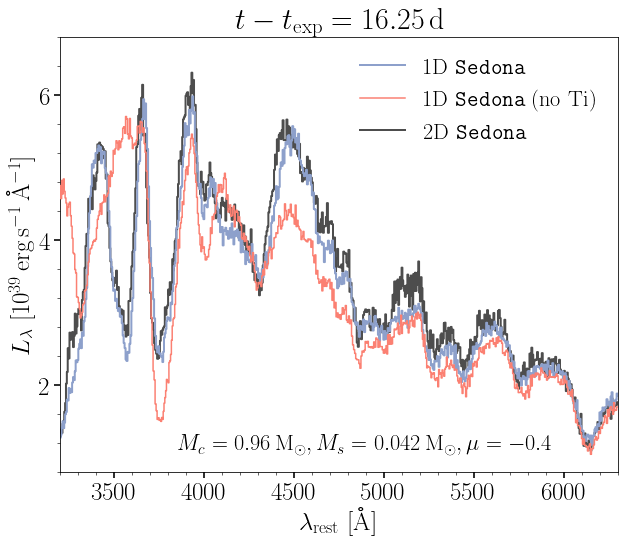

In [256]:
plt.figure(figsize=(10, 8))

x, y = plot_box_spec(dat_Ti[:, 0], dat_Ti[:, 1] / 1e39)
plt.plot(
    x, y,
    color="#8da0cb",
    label=r"$\mathrm{1D}\ \texttt{Sedona}$",
    zorder=1,
    lw=2,
)

x, y = plot_box_spec(dat_no_Ti[:, 0], dat_no_Ti[:, 1] / 1e39)
plt.plot(
    x, y,
    color="#fb8072",
    label=r"$\mathrm{1D}\ \texttt{Sedona}\ (\mathrm{no\ Ti})$",
    zorder=20,
    lw=1.5,
)

x, y = plot_box_spec(dat_2D[:, 0], dat_2D[:, 1] / 1e39)
plt.plot(
    x, y,
    color="0.3",
    zorder=-10,
    lw=2,
    label=r"$\mathrm{2D}\ \texttt{Sedona}$",
)
# plt.plot(
#     spec2[:, 0] / (1 + z),
#     spec2[:, 1]
#     * 1.8e14
#     * 10 ** (-0.4 * (distmod - calALambda(wv=spec2[:, 0], EBV=0.032, RV=3.1))),
#     color="k",
#     zorder=-10,
#     label=r"$\mathrm{Kast}\ \mathrm{+0\,d}$",
# )

# plt.fill_between(
#     dat_Ti[:, 0],
#     dat_Ti[:, 1] / 1e39,
#     dat_no_Ti[:, 1] / 1e39,
#     color="#fb8072",
#     alpha=0.4,
#     zorder=-11
# )
plt.xlim(3200, 6300)
plt.ylim(0.8, 6.8)

plt.legend(prop={"size": 22.5}, frameon=False)

plt.xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
plt.ylabel(r"$L_\lambda\ [10^{39}\,\mathrm{erg\,s^{-1}\,\r{A}^{-1}}]$")
# plt.ylabel(r"$\mathrm{Scaled}\ f_\lambda + \mathrm{offset}$")
plt.yticks([])

plt.gca().xaxis.set_major_locator(MultipleLocator(500))
plt.gca().xaxis.set_minor_locator(MultipleLocator(100))
plt.gca().yaxis.set_major_locator(MultipleLocator(2))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.4))

plt.title(r"$t - t_\mathrm{exp} = 16.25\,\mathrm{d}$", pad=10)
plt.text(
    4900,
    1.1,
    r"$M_c=0.96\,\mathrm{M_\odot}, M_s=0.042\,\mathrm{M_\odot}, \mu=-0.4$",
    fontsize=22.5,
    ha="center",
)

plt.savefig("../paper/figures/Ti_II.pdf", bbox_inches="tight")

In [225]:
with h5py.File("./Shen+21_model/plt_d6e5_w11_16.25d.h5", "r") as f:
    print(f.keys())
    T_gas, T_rad = np.array(f["T_gas"]), np.array(f["T_rad"])
    rho = np.array(f["n_elec"])
    v = np.array(f["velr"]) / 1e5
    # print(np.array(f["zonedata"]["50"]["Z_2"]["ion_fraction"]))
    Si_ion = np.array(
        [
            np.array(f["zonedata"]["{}".format(i)]["Z_14"]["ion_fraction"])
            * np.arange(14 + 1)
            for i in range(90)
        ]
    )
    Si_dens = np.array(
        [
            np.array(f["zonedata"]["{}".format(i)]["Z_14"]["n_dens"])
            for i in range(90)
        ]
    )
    Ti_ion = np.array(
        [
            np.array(f["zonedata"]["{}".format(i)]["Z_22"]["ion_fraction"])
            * np.arange(22 + 1)
            for i in range(90)
        ]
    )
    Ti_dens = np.array(
        [
            np.array(f["zonedata"]["{}".format(i)]["Z_22"]["n_dens"])
            for i in range(90)
        ]
    )
    Si_ion = np.where(Si_ion > 0, Si_ion, 0)
    Ti_ion = np.where(Ti_ion > 0, Ti_ion, 0)

    Si_mean = np.sum(Si_ion, axis=1)
    Ti_mean = np.sum(Ti_ion, axis=1)
    Si_II = Si_ion[:, 1]
    Ti_II = Ti_ion[:, 1]

<KeysViewHDF5 ['T_gas', 'T_rad', 'e_nuc_dep', 'e_nuc_emit', 'n_elec', 'nu', 'planck_mean', 'r', 'r_inner', 'rho', 'rosseland_mean', 'time', 'velr', 'zonedata']>


(0.0001, 10000000.0)

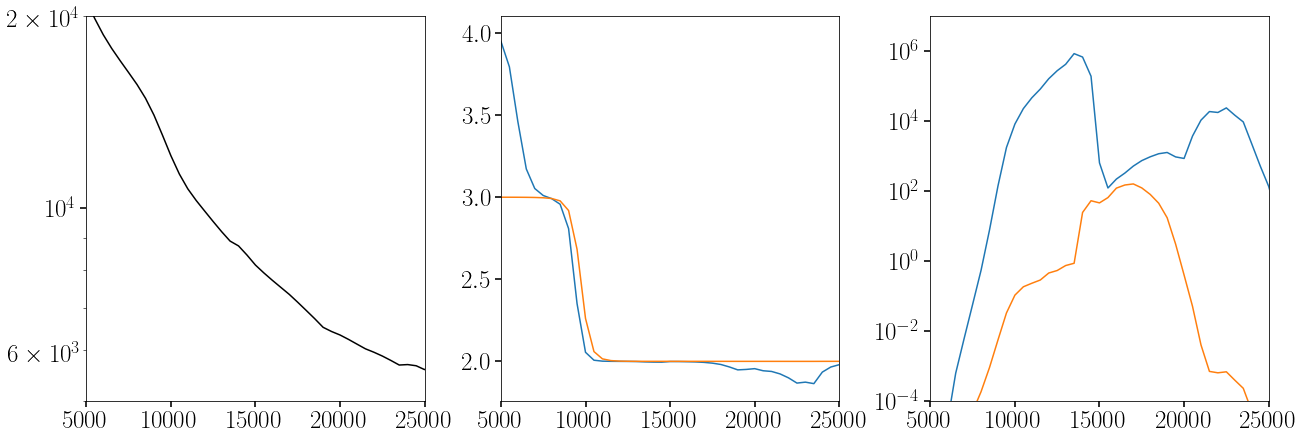

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, constrained_layout=True)
ax[0].plot(v, T_gas, color='k')
# ax[0].plot(v, T_rad)
# plt.plot(v, Si_dens / 1e8)
# plt.plot(v, Ti_dens / 1e8)
ax[1].plot(v, Si_mean)
ax[1].plot(v, Ti_mean)
ax[2].plot(v, Si_II * Si_dens.ravel())
ax[2].plot(v, Ti_II * Ti_dens.ravel())

ax[0].set_yscale("log")
ax[2].set_yscale("log")

ax[0].set_xlim(5000, 25000)
ax[0].set_ylim(5e3, 2e4)
ax[2].set_ylim(1e-4, 1e7)

In [224]:
v[35], T_gas[35]*8.67e-5, Ti_dens[35], rho[35]

(18000.0, 0.6007205506347657, array([813311.00446529]), 12004193.0)

In [230]:
Si_II.shape, Si_dens.shape

((90,), (90, 1))